# 2D ML cDFT:

This notebook's repository accompanies the publication following publication:



**Neural density functional theory in higher dimensions with convolutional layers**

*Felix Glitsch, Jens Weimar, Martin Oettel, [Phys. Rev. E **111**, 055305](https://doi.org/10.1103/PhysRevE.111.055305) (2025)*



## Purpose of this Project:

Classical density functional theory is an efficient tool to efficiently calculate structural and thermodynamic properties in equilibrium colloidal and molecular systems once the functional is known. For most systems it, however, is not and machine learning has been demonstrated to be a suitable tool for this. The approach by Sammüller et al. is especially promising (described in his notebook https://github.com/sfalmo/NeuralDFT-Tutorial) and has already been extended to various situations, but always kept in a 1D geometry. In this project we now reformulated the the idea by using convoltional layers, which made the network much more efficient, and a network architecture similar to FMT. The resulting model can efficienlty be applied to fully 2 dimensional problems as is demonstrated in this notbook.


## Purpose of this Notebook:

This short notebook only serves as a starting point to get an overview on how to acess the code. It neither serves as an explanation of the code (for what the according functions called in the notebook must be looked) nor as an explanation of the method (this is described in the paper).


## Generating training data:

For actual production one uses data obtained by GCMC simulations (see the paper). Since performing these simulations take long (which is one of the main reasons to use DFT instead), this notebook just uses a DFT code to produce some training data.

In [1]:
# Importing the necessary libraries
# Add the src directory to the Python path
from pdf2image import convert_from_path
from IPython.display import display
import matplotlib.pyplot as plt
import os
import numpy as np
import shutil
import sys

# Get the notebook directory
NOTEBOOK_DIR = os.getcwd()

# Construct the path to the 'src' directory
SRC_DIR = os.path.join(NOTEBOOK_DIR, '..', 'src')  # Relative path

# Add the 'src' directory to the Python path
sys.path.insert(0, os.path.abspath(SRC_DIR))

from src.training import MLTraining, load_MLTraining
from src.training.models import Model_Bay, Model_FMT, Model_FMT2
from src.create_df import create_td
from src.reservoir_utils import plot_data_folder
from config import PLAT_TRAIN_PARAMS as params


# create a simulation folder with FMT
dx = 0.05
L = 10
num_systems = 50
datafolder = "examples/data/plat-dx{dx:.2f}".format(dx=dx).replace(".", "_")


# create a folder with random potentials if it does not exist
# or if it does not contain the required number of systems
if (
    not os.path.exists(datafolder) or
    not os.path.exists(datafolder + "/rho/rho_" + str(num_systems) + ".csv")
):
    create_td(
        datafolder,     # path to the folder
        num_systems,    # number of systems
        1e-6,           # tolerance for rho
        L,              # length of the box
        dx,             # grid spacing
        8,             # max number of sinusoids
        0.2,            # min and max sin amplitude
        0.8,
        2,              # max period
        4,              # max number of plateaus
        1,              # max height of plateaus
        0.75,           # min and max size of plateaus
        3.0,
        0,              # min and max rotation of plateaus
        np.pi/2,
        np.pi/6,        # min and max angle of parallelograms
        np.pi/2,
        ["n", "b"],     # wall types ("n" for no wall, "b" for box)
        0.1,            # min and max wall height
        1.0,            # min and max wall height
        -1.0,           # min and max mu
        5.0)
# plot profiles of the data folder
if not os.path.exists(datafolder + "/plots"):
    plot_data_folder(datafolder)


creating random potentials...done.
creating rho files...
	getting fmt rho function... done.
	starting iterations... 
	 50 / 50
done.
Plotting folder  examples/data/plat-dx0_05
Plotting  50 / 50

## Setting up and Training a Model

**(Warning: This will take quite some time)**

These profiles can now be used to train the model. As an example, we use a model with 16 convolutional kernels here.

In [2]:
# create a model
model = Model_FMT2(int(np.ceil(1/dx)), Nn=16,
                   hidden_channels=48, hidden_layers=4)

# create a MLTraining object
mlt = MLTraining("examples/plat_mlt_dx" + ("%.2f" % dx).replace(".", "_"), model=model, datafolder=datafolder, L=L, dx=dx,
                 batchsize=params["bs"], lr_start=params["lrs"], lr_decay=params["lrd"], windowed=True)

# load the model if it exists
if os.path.exists(mlt.model_savepath):
    mlt = load_MLTraining(mlt.workspace)
    print("loaded training session from %s" % mlt)


# train the model
mlt.train(70 - mlt.trained_epochs)

start training of following model with data from folder examples/data/plat-dx0_05 for 70 epochs
writer path:  examples/plat_mlt_dx0_05/tb_logs
Model_FMT2(
  (omegas1): Conv2d(16, 16, kernel_size=(41, 41), stride=(1, 1), groups=16, bias=False)
  (omegas2): Conv2d(16, 16, kernel_size=(41, 41), stride=(1, 1), groups=16, bias=False)
  (pad): CircularPad2d((20, 20, 20, 20))
  (sum_channels): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (phi): Sequential(
    (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1))
    (1): Swish()
    (2): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
    (3): Swish()
    (4): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
    (5): Swish()
    (6): Conv2d(48, 16, kernel_size=(1, 1), stride=(1, 1))
    (7): Swish()
  )
)
total parameters: 60112
loading data... done! 163584 training samples
size of windows: 81x81
number of batches in training set: 1704
start training...
LR will be 4.93e-05 at the end of training
Training will approximat

(Model_FMT2(
   (omegas1): Conv2d(16, 16, kernel_size=(41, 41), stride=(1, 1), groups=16, bias=False)
   (omegas2): Conv2d(16, 16, kernel_size=(41, 41), stride=(1, 1), groups=16, bias=False)
   (pad): Identity()
   (sum_channels): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (phi): Sequential(
     (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1))
     (1): Swish()
     (2): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
     (3): Swish()
     (4): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
     (5): Swish()
     (6): Conv2d(48, 16, kernel_size=(1, 1), stride=(1, 1))
     (7): Swish()
   )
 ),
 0)

The kernels of this model can be visualized (for this model here without smoothing, they will very likely look very noisy):

First convolution's kernels:


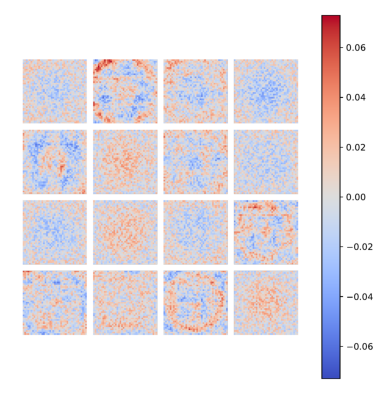

Second convolution's kernels:


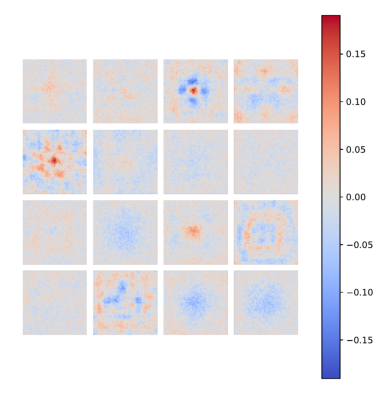

In [3]:
def display_pdf(pdf_path, dpi=200, image_width=8):
    """Display a PDF file in the notebook using pdf2image"""
    # Convert PDF to PIL images
    images = convert_from_path(pdf_path, dpi=dpi)
    
    # For multi-page PDFs, show all pages
    for i, img in enumerate(images):
        plt.figure(figsize=(image_width, image_width * img.height / img.width))  # Maintain aspect ratio
        plt.imshow(np.array(img))
        plt.axis('off')
        plt.tight_layout()
        plt.show()

if os.path.exists(mlt.workspace + "/ML_iter"):
    shutil.rmtree(mlt.workspace + "/ML_iter")

mlt.show_kernels()

print("First convolution's kernels:")
display_pdf("examples/plat_mlt_dx0_05/plots/kernels_1.pdf", image_width=4)

print("Second convolution's kernels:")
display_pdf("examples/plat_mlt_dx0_05/plots/kernels_2.pdf", image_width=4)


## Apply the Model

The trained model can be applied to calculate density profiles for given potentials, which is demonstrated in the following.
For the first 3 potentials we show plots comparing the simulated (in this case calculated via DFT) density profile to the one obtained by using the neural network. These and a lot more plots are saved in the directory `examples/plat_mlt_dx0_05/plots/iter_vs_sim/plat-dx0_05/`.

Getting Potentials from  examples/data/plat-dx0_05
Getting comparison profiles from  examples/data/plat-dx0_05
Getting model iteration profiles from  examples/plat_mlt_dx0_05/ML_iter/plat-dx0_05
Plotting to  examples/plat_mlt_dx0_05/plots/iter_vs_sim/plat-dx0_05
ML profiles do not exist. Creating them...
Creating model iteration profiles in folder 'examples/plat_mlt_dx0_05/ML_iter/plat-dx0_05'
Did not converge (step: 500, ||Δρ|| = 8.630752563476562e-05 > 1e-05 = tolerance)
Did not converge (step: 500, ||Δρ|| = 5.245208740234375e-05 > 1e-05 = tolerance)
Converged (step: 270, ||Δρ|| = 9.953975677490234e-06 < 1e-05 = tolerance)
Did not converge (step: 500, ||Δρ|| = 4.792213439941406e-05 > 1e-05 = tolerance)
Converged (step: 68, ||Δρ|| = 8.463859558105469e-06 < 1e-05 = tolerance)
Did not converge (step: 500, ||Δρ|| = 3.1828880310058594e-05 > 1e-05 = tolerance)
Did not converge (step: 500, ||Δρ|| = 6.16312026977539e-05 > 1e-05 = tolerance)
Did not converge (step: 500, ||Δρ|| = 5.03063201904

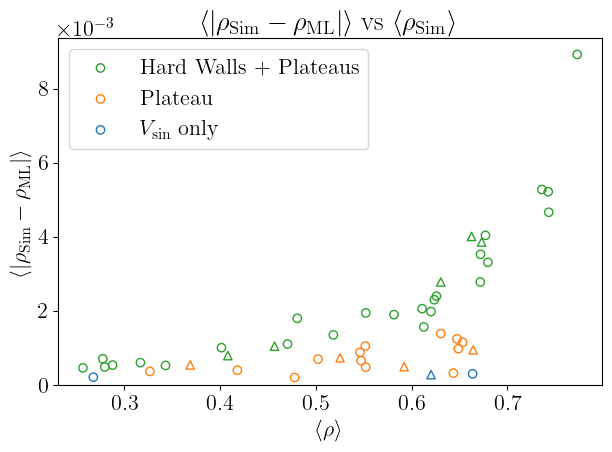

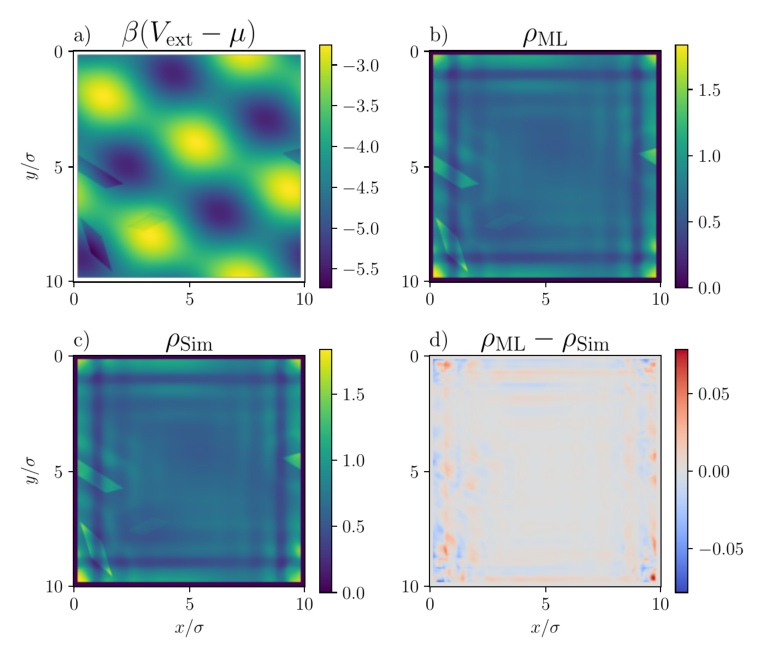

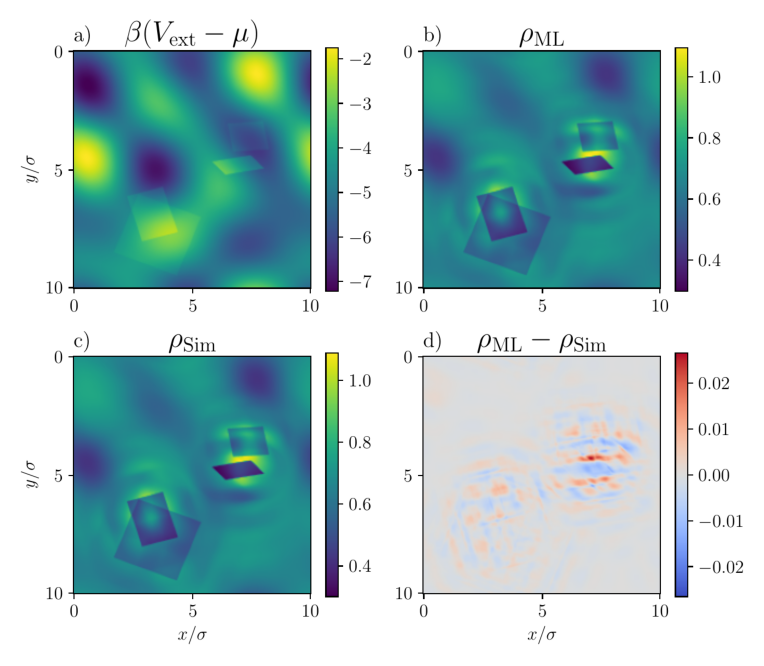

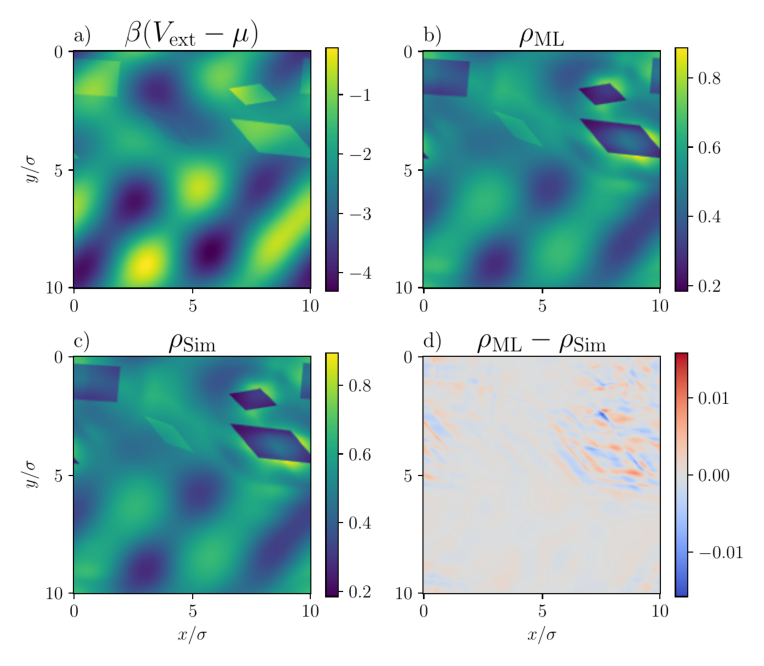

In [4]:
mlt.demo_model_iteration()

# Display the results
for i in range(1, 4):
    pdf_path = f"examples/plat_mlt_dx0_05/plots/iter_vs_sim/plat-dx0_05/comp_{i}.pdf"
    if os.path.exists(pdf_path):
        display_pdf(pdf_path)

The model can also be used to calculate the radial distribution function via the test particle route:

Did not converge (step: 750, ||Δρ|| = 1.6689300537109375e-06 > 1e-06 = tolerance)
Did not converge (step: 750, ||Δρ|| = 5.632638931274414e-06 > 1e-06 = tolerance)
Did not converge (step: 750, ||Δρ|| = 7.599592208862305e-06 > 1e-06 = tolerance)
Did not converge (step: 750, ||Δρ|| = 1.811981201171875e-05 > 1e-06 = tolerance)
Did not converge (step: 750, ||Δρ|| = 4.5299530029296875e-05 > 1e-06 = tolerance)


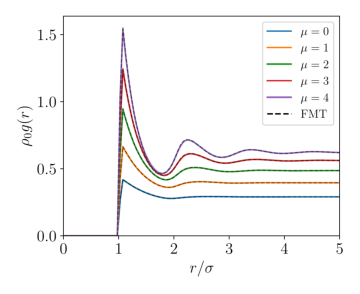

In [5]:
mlt.g_r()

display_pdf("examples/plat_mlt_dx0_05/plots/g_r_vs_FMT.pdf", image_width=4)